Numero di righe prima della rimozione: 1383
Numero di righe dopo la rimozione: 1159
MAE: 18605.79
R²: 0.9997


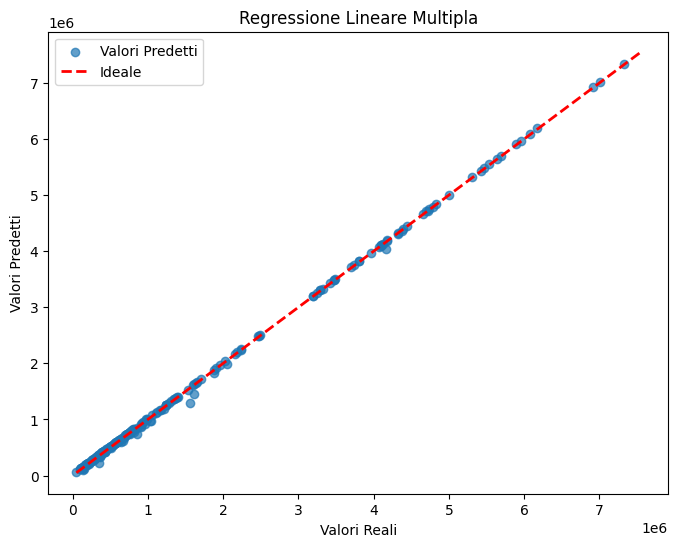

              comune       ato  abitanti  kg di rifiuti differenziati (rdi)  \
0  Aiello del Sabato  Avellino    3988.0                             837843   
1   Altavilla Irpina  Avellino    3960.0                            1036950   
2           Andretta  Avellino    1658.0                             313201   
3          Aquilonia  Avellino    1493.0                             283255   
5          Atripalda  Avellino   10440.0                            3056235   

   kg di rifiuti non differenziati (ruind)  \
0                                 436310.0   
1                                 388120.0   
2                                 162280.0   
3                                 296160.0   
5                                1921640.0   

   totale kg di rifiuti prodotti (rdi+ruind)  anno        y_pred  
0                                    1274153  2021  1.288725e+06  
1                                    1438758  2021  1.440625e+06  
2                                     475481  2

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Caricare il dataset con rilevamento automatico del separatore
df = pd.read_csv("dataset/dataset_filtrato.csv", sep=None, engine='python')

# Rimuoviamo spazi extra e standardizziamo i nomi delle colonne
df.columns = df.columns.str.strip().str.lower()

# Selezioniamo le colonne numeriche corrette
cols_to_convert = [
    "anno",
    "kg di rifiuti differenziati (rdi)",
    "kg di rifiuti non differenziati (ruind)",
    "totale kg di rifiuti prodotti (rdi+ruind)"
]

#Conversione delle colonne numeriche eliminando separatori di migliaia e convertendo in float
for col in cols_to_convert:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

#Identificare le colonne chiave
col_anno = "anno"
col_comune = "comune"
col_x1 = "kg di rifiuti differenziati (rdi)"
col_x2 = "kg di rifiuti non differenziati (ruind)"
col_target = "totale kg di rifiuti prodotti (rdi+ruind)"

#Funzione per calcolare i limiti degli outlier
def get_outlier_bounds(series, multiplier=1.3):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return lower_bound, upper_bound

#Calcolare i limiti per ogni colonna e filtrare il dataset
bounds = {col: get_outlier_bounds(df[col]) for col in [col_x1, col_x2, col_target]}
df_cleaned = df[
    (df[col_x1].between(bounds[col_x1][0], bounds[col_x1][1])) &
    (df[col_x2].between(bounds[col_x2][0], bounds[col_x2][1])) &
    (df[col_target].between(bounds[col_target][0], bounds[col_target][1]))
]


#Verifica dei dati puliti
print(f"Numero di righe prima della rimozione: {len(df)}")
print(f"Numero di righe dopo la rimozione: {len(df_cleaned)}")

#Aggiorna il dataframe con i dati puliti
df = df_cleaned

#Definire le variabili indipendenti e dipendenti
X = df[[col_x1, col_x2]]
y = df[col_target]

# Standardizzazione delle feature (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Suddivisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Creazione e addestramento del modello
model = LinearRegression()
model.fit(X_train, y_train)

#Predizioni
df['y_pred'] = model.predict(X_scaled)
y_pred_test = model.predict(X_test)

#Metriche di valutazione
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

# Grafico di regressione
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, label="Valori Predetti")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label="Ideale")
plt.xlabel("Valori Reali")
plt.ylabel("Valori Predetti")
plt.title("Regressione Lineare Multipla")
plt.legend()
plt.show()

# Salvare il dataset con le predizioni
df.to_csv("dataset/dataset_senza_outlier.csv", index=False)

# Funzione per predire i valori del 2024 per ogni comune
def predict_2024(group):
    if len(group) < 2:
        return np.nan  
    
    model = LinearRegression()
    X = group[[col_x1, col_x2]]
    y = group[col_target]
    model.fit(X, y)
    
    
    X_pred = pd.DataFrame([group[[col_x1, col_x2]].iloc[-1].values], columns=[col_x1, col_x2])
    
    return model.predict(X_pred)[0]

# Applicare il modello per ogni comune
df_pred = df.groupby(col_comune, group_keys=False)[[col_x1, col_x2, col_target]].apply(predict_2024).reset_index()

df_pred.columns = [col_comune, 'predizione_2024']

# Formattare le predizioni
df_pred['predizione_2024'] = df_pred['predizione_2024'].apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Salvare il dataset con le predizioni 2024
df_pred.to_csv("dataset/predizioni_2024.csv", index=False)

print(df.head())

